In [ ]:
import os
import requests
from zipfile import ZipFile
from google.colab import drive
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed
import random
import numpy as np
import time

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define base path for your project
base_path = "/content/drive/MyDrive/CS445/Project/Data"
os.makedirs(f"{base_path}/data/preprocessed", exist_ok=True)
os.makedirs(f"{base_path}/data/target_images", exist_ok=True)

print(f"Directories created under: {base_path}")

Directories created under: /content/drive/MyDrive/CS445/Project/Data


####  Load Preprocessed Tile Data

In [ ]:
# Load preprocessed tile data
tile_data_path = f"{base_path}/data/preprocessed/tile_colors.csv"

if os.path.exists(tile_data_path):
    tile_data = pd.read_csv(tile_data_path)
    print(f"Loaded tile data with {len(tile_data)} tiles.")
else:
    print("Preprocessed tile data not found! Ensure preprocessing is complete.")


Loaded tile data with 118287 tiles.


#### Load Target Image

Target image loaded successfully.


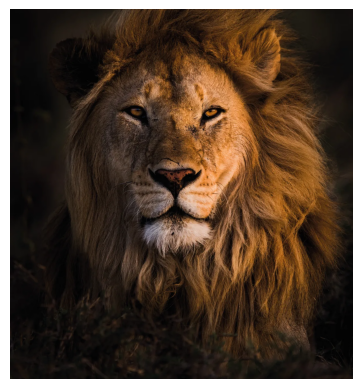

In [ ]:
# Load target image
target_image_path = f"{base_path}/data/target_images/lion.png"

if os.path.exists(target_image_path):
    target_image = cv2.imread(target_image_path)
    target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    print("Target image loaded successfully.")
    plt.imshow(target_image)
    plt.axis("off")
    plt.show()
else:
    print("Target image not found!")

#### Divide Target Image into a Grid of 10x10

In [ ]:
# Define grid size
grid_size = (10, 10)  # Adjust as needed (rows, cols)

def divide_image_into_grid(image, grid_size):

    h, w, _ = image.shape
    tile_h, tile_w = h // grid_size[0], w // grid_size[1]

    grid_colors = []
    # Use grid_size directly for iteration
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            y_start = i * tile_h
            y_end = min((i + 1) * tile_h, h)
            x_start = j * tile_w
            x_end = min((j + 1) * tile_w, w)

            cell = image[y_start:y_end, x_start:x_end]
            avg_color = np.mean(cell.reshape(-1, 3), axis=0)
            grid_colors.append(avg_color)

    return grid_colors, (tile_h, tile_w)

# Compute grid colors
grid_colors, tile_size = divide_image_into_grid(target_image, grid_size)
print(f"Grid divided into {len(grid_colors)} cells.")


Grid divided into 100 cells.


#### Visualize the Grid

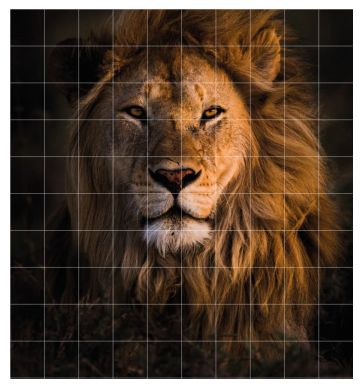

In [ ]:
# Visualize grid
def visualize_grid(image, grid_size):
    h, w, _ = image.shape
    tile_h, tile_w = h // grid_size[0], w // grid_size[1]

    for i in range(0, h, tile_h):
        cv2.line(image, (0, i), (w, i), color=(255, 255, 255), thickness=1)
    for j in range(0, w, tile_w):
        cv2.line(image, (j, 0), (j, h), color=(255, 255, 255), thickness=1)

    return image

grid_image = visualize_grid(target_image.copy(), grid_size)
plt.imshow(grid_image)
plt.axis("off")
plt.show()


#### Tile Matching Implementation

In [ ]:
# Function to find the closest matching tile using vectorized operations
def find_closest_tiles(grid_colors, tile_data):

    tile_colors = np.array([eval(color) for color in tile_data['avg_color_RGB']])
    matched_tiles = []
    for grid_color in grid_colors:
        distances = np.linalg.norm(tile_colors - np.array(grid_color), axis=1)  # Vectorized distance computation
        closest_index = np.argmin(distances)  #  index of the closest tile
        matched_tiles.append(tile_data.iloc[closest_index]['image_name'])

    return matched_tiles

In [ ]:
def create_mosaic(target_image, matched_tiles, tile_data, tile_dir, grid_size):

    h, w, _ = target_image.shape
    tile_h, tile_w = h // grid_size[0], w // grid_size[1]

    print(f"Target Image Dimensions: {target_image.shape}")
    print(f"Number of matched tiles: {len(matched_tiles)}")
    print(f"Grid size: {grid_size}")

    mosaic = np.zeros_like(target_image)
    index = 0

    # Use grid_size directly for iteration
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if index >= len(matched_tiles):
                raise IndexError("Not enough matched tiles provided .")

            y_start = i * tile_h
            y_end = min((i + 1) * tile_h, h)
            x_start = j * tile_w
            x_end = min((j + 1) * tile_w, w)

            tile_path = os.path.join(tile_dir, matched_tiles[index])
            tile_image = cv2.imread(tile_path)
            if tile_image is None:
                raise FileNotFoundError(f"Tile image not found: {tile_path}")

            # Resize tile to fit the current grid cell
            tile_resized = cv2.resize(tile_image, (x_end - x_start, y_end - y_start))
            mosaic[y_start:y_end, x_start:x_end] = tile_resized

            index += 1

    if np.any(mosaic):
        print("Mosaic generated successfully.")
    else:
        print("Mosaic is completely black. Check tile loading or placement logic.")

    return mosaic

In [ ]:
start_time = time.time()
# Match tiles for all grid cells
matched_tiles = find_closest_tiles(grid_colors, tile_data)

print(f"Tile matching completed for {len(matched_tiles)} grid cells.")

Tile matching completed for 100 grid cells.


Target Image Dimensions: (1294, 1200, 3)
Number of matched tiles: 100
Grid size: (10, 10)
Mosaic generated successfully.
Mosaic saved at: /content/drive/MyDrive/CS445/Project/Data/data/preprocessed/mosaic_lion_10x10.jpg


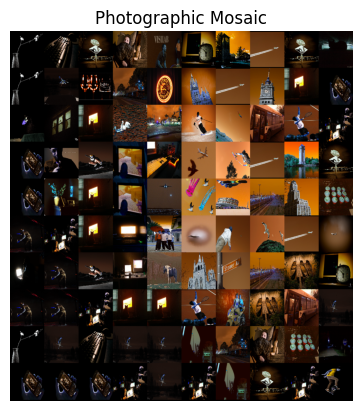

Total time taken: 4.016577243804932 seconds


In [ ]:
# Generate the mosaic
tile_dir = f"{base_path}/data/tiles/train2017"
mosaic_image = create_mosaic(target_image, matched_tiles, tile_data, tile_dir, grid_size)

# Save and display the mosaic
output_path = f"{base_path}/data/preprocessed/mosaic_lion_10x10.jpg"
cv2.imwrite(output_path, cv2.cvtColor(mosaic_image, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR for saving
print(f"Mosaic saved at: {output_path}")

plt.imshow(mosaic_image)
plt.axis("off")
plt.title("Photographic Mosaic")
plt.show()
end_time = time.time()
tile_matching_time = end_time - start_time
print(f"Total time taken: {end_time - start_time} seconds")

In [ ]:
print(f"Total time taken: {tile_matching_time} seconds")

Total time taken: 4.016577243804932 seconds


#### Tile Diversity Constraints

Objective:
Ensure tiles are not reused too frequently in the mosaic, avoiding redundancy and improving visual interest.

Implementation Steps:
Add a rule to restrict tile reuse:
Example: Allow a tile to be used only once per row or once every N grid cells.
Track tile usage dynamically during the matching process.

In [ ]:
def find_closest_tile_with_constraints(grid_colors, tile_data, reuse_limit=1):

    tile_colors = np.array([eval(color) for color in tile_data['avg_color_RGB']])
    tile_usage = {tile: 0 for tile in tile_data['image_name']}
    matched_tiles = []

    for grid_color in grid_colors:
        # Compute distances to all tiles
        distances = np.linalg.norm(tile_colors - np.array(grid_color), axis=1)

        # Sort tiles by distance and find the first unused tile
        sorted_indices = np.argsort(distances)
        for idx in sorted_indices:
            tile_name = tile_data.iloc[idx]['image_name']
            if tile_usage[tile_name] < reuse_limit:
                matched_tiles.append(tile_name)
                tile_usage[tile_name] += 1
                break

    return matched_tiles



In [ ]:
start_time = time.time()
matched_tiles = find_closest_tile_with_constraints(grid_colors, tile_data, reuse_limit=3)
print("Tile matching with diversity constraints completed.")


Tile matching with diversity constraints completed.


Target Image Dimensions: (1294, 1200, 3)
Number of matched tiles: 100
Grid size: (10, 10)
Mosaic generated successfully.
Mosaic saved at: /content/drive/MyDrive/CS445/Project/Data/data/preprocessed/mosaic_lion_10x10_diversity.jpg


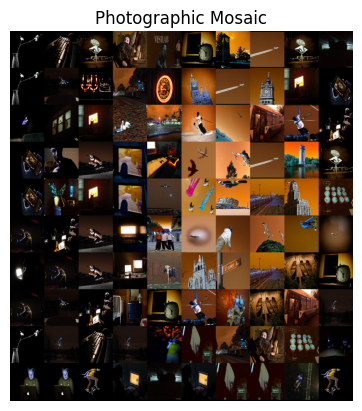

Total time taken: 5.448764324188232 seconds


In [ ]:
# Generate the mosaic
tile_dir = f"{base_path}/data/tiles/train2017"
mosaic_image = create_mosaic(target_image, matched_tiles, tile_data, tile_dir, grid_size)

# Save and display the mosaic
output_path = f"{base_path}/data/preprocessed/mosaic_lion_10x10_diversity.jpg"
cv2.imwrite(output_path, cv2.cvtColor(mosaic_image, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR for saving
print(f"Mosaic saved at: {output_path}")

plt.imshow(mosaic_image)
plt.axis("off")
plt.title("Photographic Mosaic")
plt.show()
end_time = time.time()
tile_matching_time = end_time - start_time
print(f"Total time taken: {end_time - start_time} seconds")

In [ ]:
print(f"Total time taken: {tile_matching_time} seconds")

Total time taken: 5.448764324188232 seconds


#### Adaptive Tiling Based on Image Detail
Objective:
Adaptively adjust the tile sizes based on the level of detail in different regions of the target image:

Use smaller tiles in regions with high detail to preserve fine structures.
Use larger tiles in simpler regions to reduce computational load.

In [ ]:
def compute_detail_map(image, grid_size):

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

    h, w = edges.shape
    tile_h, tile_w = h // grid_size[0], w // grid_size[1]

    detail_map = np.zeros(grid_size)

    # Compute detail score for each grid cell
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):

            y_start = i * tile_h
            y_end = min((i + 1) * tile_h, h)
            x_start = j * tile_w
            x_end = min((j + 1) * tile_w, w)

            # Extract cell and compute detail score
            cell = edges[y_start:y_end, x_start:x_end]
            detail_score = np.sum(cell)  # Higher score = more edges
            detail_map[i, j] = detail_score

    if detail_map.max() != detail_map.min():  # Prevent division by zero
        detail_map = 1 + (4 * (detail_map - detail_map.min()) / (detail_map.max() - detail_map.min()))
    else:
        detail_map.fill(1)

    print(f"Detail map shape: {detail_map.shape}")
    print(f"Detail score range: {detail_map.min():.2f} to {detail_map.max():.2f}")

    return detail_map


In [ ]:
def divide_image_adaptively(image, detail_map, grid_size):

    h, w, _ = image.shape
    tile_h, tile_w = h // grid_size[0], w // grid_size[1]
    adaptive_tiles = []

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            scale = int(detail_map[i, j])  # Scale factor for tile size
            cell_h, cell_w = tile_h // scale, tile_w // scale

            start_y, end_y = i * tile_h, min((i + 1) * tile_h, h)
            start_x, end_x = j * tile_w, min((j + 1) * tile_w, w)

            # Extract the region of the image
            grid_cell = image[start_y:end_y, start_x:end_x]
            adaptive_tiles.append((grid_cell, (start_y, end_y, start_x, end_x)))

    return adaptive_tiles


In [ ]:
def create_adaptive_mosaic(image, adaptive_tiles, tile_data):

    mosaic = np.zeros_like(image)

    for grid_cell, (start_y, end_y, start_x, end_x) in adaptive_tiles:
        grid_color = np.mean(grid_cell.reshape(-1, 3), axis=0)  # Compute average color
        closest_tile = find_closest_tiles([grid_color], tile_data)[0]

        tile_path = os.path.join(tile_dir, closest_tile)
        tile_image = cv2.imread(tile_path)
        resized_tile = cv2.resize(tile_image, (end_x - start_x, end_y - start_y))

        # Place the tile in the mosaic
        mosaic[start_y:end_y, start_x:end_x] = resized_tile

    return mosaic



Detail map shape: (10, 10)
Detail score range: 1.00 to 5.00


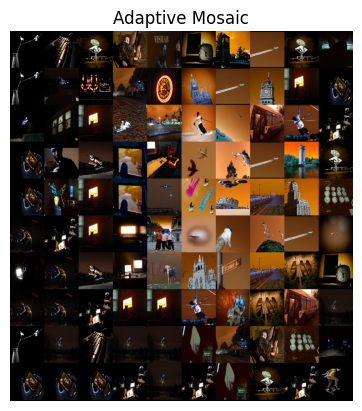

Total time taken: 199.84901881217957 seconds


In [ ]:
start_time = time.time()

# Generate Adaptive Mosaic
detail_map = compute_detail_map(target_image, grid_size=(10, 10))
adaptive_tiles = divide_image_adaptively(target_image, detail_map, grid_size=(10, 10))
adaptive_mosaic = create_adaptive_mosaic(target_image, adaptive_tiles, tile_data)

# Save and Display
output_path = f"{base_path}/data/preprocessed/adaptive_mosaic_lion_10x10.jpg"
cv2.imwrite(output_path, cv2.cvtColor(adaptive_mosaic, cv2.COLOR_RGB2BGR))
plt.imshow(adaptive_mosaic)
plt.axis("off")
plt.title("Adaptive Mosaic")
plt.show()

end_time = time.time()
tile_matching_time_adaptive = end_time - start_time
print(f"Total time taken: {end_time - start_time} seconds")

In [ ]:
print(f"Total time taken: {tile_matching_time_adaptive} seconds")

Total time taken: 199.84901881217957 seconds


#### Alpha Blending

In [ ]:
def alpha_blend_tiles(tile1, tile2, alpha=0.5):

    # Ensure both tiles are the same size
    assert tile1.shape == tile2.shape, "Tiles must be the same size for blending."
    return cv2.addWeighted(tile1, alpha, tile2, 1 - alpha, 0)

def create_alpha_blended_mosaic(image, adaptive_tiles, tile_data, blend_alpha=0.5):

    mosaic = np.zeros_like(image)

    for i, (grid_cell, (start_y, end_y, start_x, end_x)) in enumerate(adaptive_tiles):
        grid_color = np.mean(grid_cell.reshape(-1, 3), axis=0)  # Compute average color
        closest_tile = find_closest_tiles([grid_color], tile_data)[0]

        tile_path = os.path.join(tile_dir, closest_tile)
        tile_image = cv2.imread(tile_path)
        if tile_image is None:
            print(f"Failed to load tile: {tile_path}")
            continue

        # Resize the matched tile to fit the grid cell
        resized_tile = cv2.resize(tile_image, (end_x - start_x, end_y - start_y))

        # Blend with the existing mosaic content if not the first row or column
        if i > 0:
            mosaic[start_y:end_y, start_x:end_x] = alpha_blend_tiles(
                mosaic[start_y:end_y, start_x:end_x], resized_tile, blend_alpha
            )
        else:
            mosaic[start_y:end_y, start_x:end_x] = resized_tile

    return mosaic

In [ ]:
start_time = time.time()

In [ ]:
detail_map = compute_detail_map(target_image, grid_size=(10, 10))

Detail map shape: (10, 10)
Detail score range: 1.00 to 5.00


In [ ]:
adaptive_tiles = divide_image_adaptively(target_image, detail_map, grid_size=(10, 10))

In [ ]:
tile_dir = f"{base_path}/data/tiles/train2017"

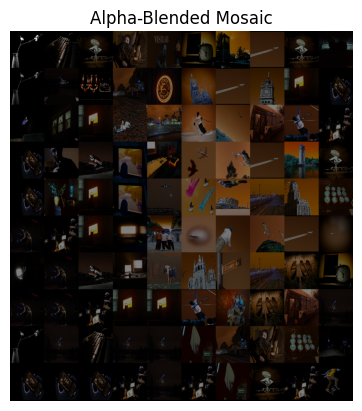

In [ ]:

# Generate Alpha-Blended Mosaic
alpha_blended_mosaic = create_alpha_blended_mosaic(target_image, adaptive_tiles, tile_data, blend_alpha=0.5)

# Save and Display
output_path = f"{base_path}/data/preprocessed/alpha_blended_mosaic.jpg"
cv2.imwrite(output_path, cv2.cvtColor(alpha_blended_mosaic, cv2.COLOR_RGB2BGR))
plt.imshow(alpha_blended_mosaic)
plt.axis("off")
plt.title("Alpha-Blended Mosaic")
plt.show()

end_time = time.time()

In [ ]:
tile_matching_time_alpha = end_time - start_time
print(f"Total time taken: {end_time - start_time} seconds")

Total time taken: 198.43985986709595 seconds


#### Poisson Blending
Implementation Steps:
Define the overlap region and mask.
Use OpenCV’s cv2.seamlessClone() for blending tiles seamlessly.

In [ ]:
def poisson_blend_tiles(tile, mosaic, start_y, end_y, start_x, end_x):
    try:
        target_h, target_w = end_y - start_y, end_x - start_x
        if target_h <= 0 or target_w <= 0:
            return mosaic

        # resized_tile is currently in RGB
        resized_tile = cv2.resize(tile, (target_w, target_h))

        # ROI from mosaic (also in RGB)
        roi = mosaic[start_y:end_y, start_x:end_x].copy()

        if np.sum(roi) == 0:
            mosaic[start_y:end_y, start_x:end_x] = resized_tile
            return mosaic

        # Convert both to BGR for seamlessClone
        resized_tile_bgr = cv2.cvtColor(resized_tile, cv2.COLOR_RGB2BGR)
        roi_bgr = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)

        mask = np.full((target_h, target_w), 255, dtype=np.uint8)
        center = (target_w // 2, target_h // 2)

        # Perform Poisson blending in BGR
        blended_bgr = cv2.seamlessClone(
            resized_tile_bgr,
            roi_bgr,
            mask,
            center,
            cv2.MIXED_CLONE
        )

        # Convert blended result back to RGB
        blended = cv2.cvtColor(blended_bgr, cv2.COLOR_BGR2RGB)
        mosaic[start_y:end_y, start_x:end_x] = blended

        return mosaic

    except Exception as e:
        print(f"Error in poisson_blend_tiles: {str(e)}")
        return mosaic



def create_poisson_blended_mosaic(image, adaptive_tiles, tile_data, tile_dir):
    mosaic = np.zeros_like(image)

    batch_size = 10
    for i in range(0, len(adaptive_tiles), batch_size):
        batch = adaptive_tiles[i:i + batch_size]

        for grid_cell, (start_y, end_y, start_x, end_x) in batch:
            grid_color = np.mean(grid_cell.reshape(-1, 3), axis=0)
            closest_tile = find_closest_tiles([grid_color], tile_data)[0]
            tile_path = os.path.join(tile_dir, closest_tile)
            try:
                tile_image = cv2.imread(tile_path)
                if tile_image is None:
                    continue
                # Convert tile to RGB to maintain consistency
                tile_image = cv2.cvtColor(tile_image, cv2.COLOR_BGR2RGB)

                mosaic = poisson_blend_tiles(
                    tile_image, mosaic,
                    start_y, end_y, start_x, end_x
                )
            except Exception as e:
                print(f"Error processing tile {closest_tile}: {str(e)}")
                continue

    return mosaic.astype(np.uint8)

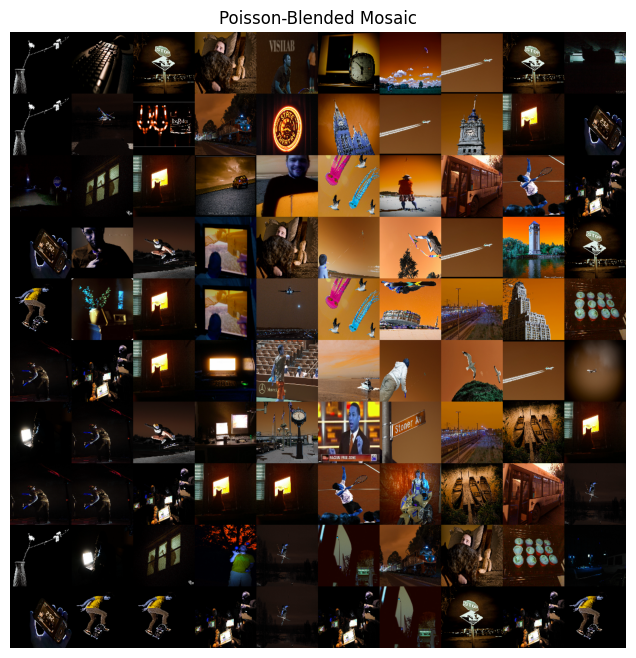

In [ ]:
grid_size = (10, 10)
start_time = time.time()
detail_map = compute_detail_map(target_image, grid_size=grid_size)
adaptive_tiles = divide_image_adaptively(target_image, detail_map, grid_size=grid_size)
tile_dir = f"{base_path}/data/tiles/train2017"
poisson_blended_mosaic = create_poisson_blended_mosaic(
    target_image, adaptive_tiles, tile_data, tile_dir
)

end_time = time.time()
elapsed_time = end_time - start_time

# Save and display
output_path = f"{base_path}/data/preprocessed/poisson_mosaic_lion_{grid_size[0]}x{grid_size[1]}.jpg"


cv2.imwrite(output_path, cv2.cvtColor(poisson_blended_mosaic, cv2.COLOR_RGB2BGR))
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(poisson_blended_mosaic, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Poisson-Blended Mosaic')
plt.show()

In [ ]:
print(f"Time taken: {elapsed_time:.5f} seconds")

Time taken: 207.64818 seconds
